In [1]:
import torch
import torchvision as torchvision
from bayesian_network.bayesian_network import BayesianNetwork, Node
from bayesian_network.common.torch_settings import TorchSettings
from bayesian_network.inference_machines.torch_sum_product_algorithm_inference_machine import \
    TorchSumProductAlgorithmInferenceMachine
from bayesian_network.interfaces import IInferenceMachine
from bayesian_network.optimizers.em_optimizer import EmOptimizer
from torchvision.transforms import transforms
from torch.nn.functional import one_hot

num_observations = 5000
device = torch.device('cpu')

# Prepare training data set
selected_labels = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
num_classes = len(selected_labels)

mnist = torchvision.datasets.MNIST('./mnist', train=True, transform=transforms.ToTensor(), download=True)
selection = [(data, label) for data, label in zip(mnist.train_data, mnist.train_labels) if label in selected_labels] \
    [0:num_observations]
training_data = torch.stack([data for data, label in selection]) \
    .ge(128).long()
true_labels = [int(label) for data, label in selection]

height, width = training_data.shape[1:3]
num_features = height * width

# Morph into evidence structure
training_data_reshaped = training_data.reshape([num_observations, num_features])

# evidence: List[num_observed_nodes x torch.Tensor[num_observations x num_states]], one-hot encoded
gamma = 0.000001
evidence = [
    node_evidence * (1-gamma) + gamma/2
    for node_evidence 
    in one_hot(training_data_reshaped.T, 2).double()
]

# Create network
Q = Node(torch.ones((num_classes), device=device, dtype=torch.double)/num_classes, name='Q')
mu = torch.rand((height, width, num_classes), dtype=torch.double)*0.2 + 0.4
mu = torch.stack([1-mu, mu], dim=3)
Ys = [
    Node(mu[iy, ix], name=f'Y_{iy}x{ix}')
    for iy in range(height)
    for ix in range(width)
]
nodes = [Q] + Ys
parents = {node: [Q] for node in Ys}
parents[Q] = []

network = BayesianNetwork(nodes, parents)

# Train network
num_iterations = 10

def inference_machine_factory(bayesian_network: BayesianNetwork) -> IInferenceMachine:
    return TorchSumProductAlgorithmInferenceMachine(
        bayesian_network=bayesian_network,
        observed_nodes=Ys,
        torch_settings=TorchSettings(torch.device('cpu'), torch.float64),
        num_iterations=8,
        num_observations=num_observations,
        callback=lambda x, y: None)

em_optimizer = EmOptimizer(network, inference_machine_factory)
em_optimizer.optimize(evidence, num_iterations, lambda ll, iteration, duration:
    print(f'Finished iteration {iteration}/{num_iterations} - ll: {ll} - it took: {duration} s'))


/Users/pimmostert/Repositories/BayesianNetwork/.venv/lib/python3.10/site-packages/torchvision/datasets/mnist.py:75: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
/Users/pimmostert/Repositories/BayesianNetwork/.venv/lib/python3.10/site-packages/torchvision/datasets/mnist.py:65: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")


Finished iteration 0/10 - ll: -2724872.9791055555 - it took: 6.590136766433716 s
Finished iteration 1/10 - ll: -951302.697405155 - it took: 4.152527093887329 s
Finished iteration 2/10 - ll: -870607.1388502368 - it took: 4.397848129272461 s
Finished iteration 3/10 - ll: -847761.2322137201 - it took: 4.370136976242065 s
Finished iteration 4/10 - ll: -837395.6638093627 - it took: 4.4223010540008545 s
Finished iteration 5/10 - ll: -831062.641499651 - it took: 4.314827919006348 s
Finished iteration 6/10 - ll: -828085.2226223011 - it took: 4.184603214263916 s
Finished iteration 7/10 - ll: -826696.6022576157 - it took: 4.232372999191284 s
Finished iteration 8/10 - ll: -826005.3606965945 - it took: 4.443222999572754 s
Finished iteration 9/10 - ll: -825516.8022795974 - it took: 4.497300148010254 s


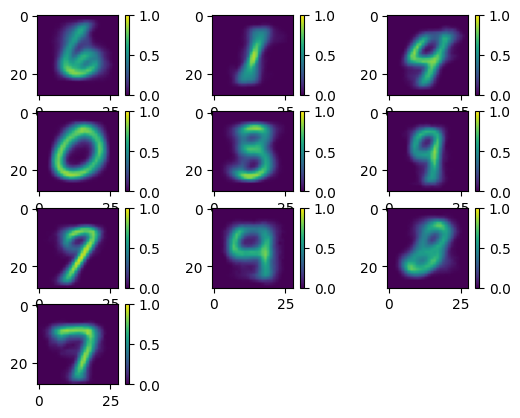

In [2]:
import matplotlib.pyplot as plt

height = 28
width = 28

Q = network.nodes[0]
Ys = network.nodes[1:]

w = torch.stack([y.cpt for y in Ys])

plt.figure()
for i in range(0, 10):
    plt.subplot(4, 3, i+1)
    plt.imshow(w[:, i, 1].reshape(height, width))
    plt.colorbar()
    plt.clim(0, 1)